In [50]:
import os

from PIL import Image
from tqdm import tqdm
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms,datasets

# Unet 구현

## DobleConv

In [40]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

## Down

In [41]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    
    def forward(self, x):
        return self.maxpool_conv(x)

## Up

In [42]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels//2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, out_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX//2, diffX - diffX//2,
                        diffY//2, diffY - diffY//2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

## OutConv

In [43]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        return self.conv(x)

## Main

In [44]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [45]:
class CustomDataset(torch.utils.data.Dataset): 
     # torch.utils.data.Dataset 이라는 파이토치 base class를 상속받아 
     # 그 method인 __len__(), __getitem__()을 오버라이딩 해줘서 
     # 사용자 정의 Dataset class를 선언한다
    def __init__(self, img_path_list, label_path_list, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_input = img_path_list
        lst_label = label_path_list
        
        lst_input.sort()
        lst_label.sort()

        self.lst_input = lst_input
        self.lst_label = lst_label

    def __len__(self):
        return len(self.lst_label)

    # 여기가 데이터 load하는 파트
    def __getitem__(self, index):
        input_path = self.lst_input[index]
        label_path = self.lst_label[index]
        
        inputs = Image.open(input_path)
        label = Image.open(label_path)

# normalize, 이미지는 0~255 값을 가지고 있어 이를 0~1사이로 scaling
        inputs = np.array(inputs)/255.0
        label = np.array(label)/255.0
        inputs = inputs.astype(np.float32)
        label = label.astype(np.float32)
        
# 인풋 데이터 차원이 2이면, 채널 축을 추가해줘야한다. 
# 파이토치 인풋은 (batch, 채널, 행, 열)

        if label.ndim == 2:  
            label = label[:,:,np.newaxis]
        if inputs.ndim == 2:  
            inputs = inputs[:,:,np.newaxis] 

        data = {'input':inputs, 'label':label}

        if self.transform:
            data['input'] = self.transform(data['input'])
            data['label'] = self.transform(data['label'])
# transform에 할당된 class 들이 호출되면서 __call__ 함수 실행
        return data

In [46]:
def get_train_data(data_dir):
    img_path_list = []
    label_path_list = []
    
    input_path = os.path.join(data_dir, 'fire_img')
    label_path = os.path.join(data_dir, 'label2')
    # get label
    #label_df = pd.read_csv(data_dir+'/train.csv')
    label_path_list.extend(glob(os.path.join(label_path, '*.jpg')))
    label_path_list.sort()
    
    # get image path
    for label_path in tqdm(label_path_list):
        p = label_path.split('\\')[-1]
        input_p = os.path.join(input_path, p)
        img_path_list.append(input_p)

    return img_path_list, label_path_list

In [47]:
def info_print(txt):
    print("[INFO] ",txt)

In [52]:
## 하이퍼 파라미터 설정
CFG = {
    'width':400,
    'height':400,
    'learning_rate' : 1e-5,
    'batch_size' : 4,
    'momentum' : 0.999,
    'img_scale': 0.5,
    'epochs': 100,
    'weight_decay' : 1e-8,
    'patience' : 8,
    'amp':False,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'data_dir' : 'I:\\personal\\fire\\Valid',
    'project_dir' : 'D:\\Projects\\Unet_dataset'
}



data_dir = CFG['data_dir']
ckpt_dir = os.path.join(CFG['project_dir'], 'checkpoint')
log_dir = os.path.join(CFG['project_dir'], 'log')

device = CFG['device']

# transform 적용해서 데이터 셋 불러오기
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([CFG['width'], CFG['height']]),
    transforms.Normalize(mean=0.5,std=0.5)
])

info_print('All Data Load')
img_path_list, label_path_list = get_train_data(CFG['data_dir'])
info_print(f'img_path_list: {len(img_path_list)}, \
           label_path_path: {len(label_path_list)}')

split_len = int(len(img_path_list)*0.75)

train_path_list = (img_path_list[:split_len], label_path_list[:split_len])
valid_path_list = (img_path_list[split_len:], label_path_list[split_len:])

info_print('Train Data Load')
dataset_train = CustomDataset(img_path_list=train_path_list[0],
                        label_path_list=train_path_list[1],
                        transform=transform)
# 불러온 데이터셋, 배치 size줘서 DataLoader 해주기
loader_train = DataLoader(dataset_train, batch_size = CFG['batch_size'], shuffle=True)


info_print('Valid Data Load')
# val set도 동일하게 진행
dataset_val = CustomDataset(img_path_list=valid_path_list[0],
                        label_path_list=valid_path_list[1],
                        transform = transform)
loader_val = DataLoader(dataset_val, batch_size=CFG['batch_size'], shuffle=True)

# 네트워크 불러오기
model = UNet(n_channels=3, n_classes=2, bilinear=False) # device : cpu or gpu
model = model.to(memory_format = torch.channels_last)
model = model.to(device=device)

# loss 정의
fn_loss = nn.BCEWithLogitsLoss().to(device)

# Optimizer 정의
optimizer = optim.RMSprop(model.parameters(), lr = CFG["learning_rate"],
                        momentum=CFG["momentum"], foreach=True) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=CFG['patience'])
grad_scaler = torch.cuda.amp.GradScaler(enabled=CFG['amp'])
criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()
global_step = 0

# 기타 variables 설정
num_train = len(dataset_train)
num_val = len(dataset_val)

num_train_for_epoch = np.ceil(num_train/CFG['batch_size']) # np.ceil : 소수점 반올림
num_val_for_epoch = np.ceil(num_val/CFG['batch_size'])

# 기타 function 설정
fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(0,2,3,1) # device 위에 올라간 텐서를 detach 한 뒤 numpy로 변환
fn_denorm = lambda x, mean, std : (x * std) + mean 
fn_classifier = lambda x :  1.0 * (x > 0.5)  # threshold 0.5 기준으로 indicator function으로 classifier 구현

# Tensorbord
writer_train = SummaryWriter(log_dir=os.path.join(log_dir,'train'))
writer_val = SummaryWriter(log_dir = os.path.join(log_dir,'val'))
info_print('End Point')

[INFO]  All Data Load


100%|████████████████████████████████████████████████████████████████████████| 26670/26670 [00:00<00:00, 467885.59it/s]


[INFO]  img_path_list: 26670,            label_path_path: 26670
[INFO]  Train Data Load
[INFO]  Valid Data Load
[INFO]  End Point


In [60]:
print(len(dataset_train))


20002


TypeError: 'DataLoader' object is not subscriptable

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


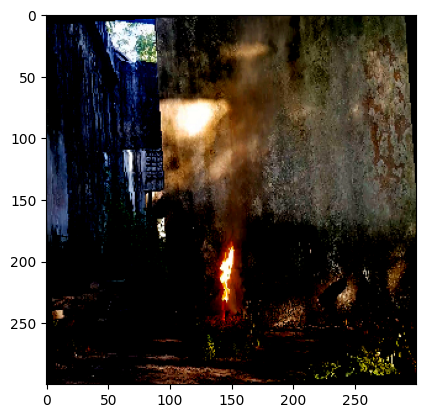

In [15]:
train_features, train_labels = dataset_train[0].values()
img = train_features
label = train_labels
plt.imshow(img.permute(1,2,0))
plt.show()

In [ ]:
plt.imshow(label.permute(1,2,0))
plt.show()

In [16]:
# 네트워크 저장하기
# train을 마친 네트워크 저장 
# net : 네트워크 파라미터, optim  두개를 dict 형태로 저장
def save(ckpt_dir,net,optim,epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net':net.state_dict(),'optim':optim.state_dict()},'%s/model_epoch%d.pth'%(ckpt_dir,epoch))

# 네트워크 불러오기
def load(ckpt_dir,net,optim):
    if not os.path.exists(ckpt_dir): # 저장된 네트워크가 없다면 인풋을 그대로 반환
        epoch = 0
        return net, optim, epoch
    
    ckpt_lst = os.listdir(ckpt_dir) # ckpt_dir 아래 있는 모든 파일 리스트를 받아온다
    ckpt_lst.sort(key = lambda f : int(''.join(filter(str,isdigit,f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir,ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net,optim,epoch

In [18]:
epochs = CFG['epochs']
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            assert images.shape[1] == model.n_channels, \
                f'Network has been defined with {model.n_channels} input channels, ' \
                f'but loaded images have {images.shape[1]} channels. Please check that ' \
                'the images are loaded correctly.'

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

            with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                masks_pred = model(images)
                if model.n_classes == 1:
                    loss = criterion(masks_pred.squeeze(1), true_masks.float())
                    loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
                else:
                    loss = criterion(masks_pred, true_masks)
                    loss += dice_loss(
                        F.softmax(masks_pred, dim=1).float(),
                        F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),
                        multiclass=True
                    )

            optimizer.zero_grad(set_to_none=True)
            grad_scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
            grad_scaler.step(optimizer)
            grad_scaler.update()

            pbar.update(images.shape[0])
            global_step += 1
            epoch_loss += loss.item()
            experiment.log({
                'train loss': loss.item(),
                'step': global_step,
                'epoch': epoch
            })
            pbar.set_postfix(**{'loss (batch)': loss.item()})

            # Evaluation round
            division_step = (n_train // (5 * batch_size))
            if division_step > 0:
                if global_step % division_step == 0:
                    histograms = {}
                    for tag, value in model.named_parameters():
                        tag = tag.replace('/', '.')
                        if not torch.isinf(value).any():
                            histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                        if not torch.isinf(value.grad).any():
                            histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                    val_score = evaluate(model, val_loader, device, amp)
                    scheduler.step(val_score)

                    info_print('Validation Dice score: {}'.format(val_score))
                    try:
                        experiment.log({
                            'learning rate': optimizer.param_groups[0]['lr'],
                            'validation Dice': val_score,
                            'images': wandb.Image(images[0].cpu()),
                            'masks': {
                                'true': wandb.Image(true_masks[0].float().cpu()),
                                'pred': wandb.Image(masks_pred.argmax(dim=1)[0].float().cpu()),
                            },
                            'step': global_step,
                            'epoch': epoch,
                            **histograms
                        })
                    except:
                        pass

    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        state_dict = model.state_dict()
        state_dict['mask_values'] = dataset.mask_values
        torch.save(state_dict, str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
        info_print(f'Checkpoint {epoch} saved!')

NameError: name 'model' is not defined